## Hourly_AEP

# Importing necessary Libraries 

In [1]:
!pip install pandas
!pip install prophet
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.svm import SVR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split, GridSearchCV

C:\Users\fatii\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Loading the dataset (AEP_hourly.csv)

In [39]:
data = pd.read_csv('AEP_hourly.csv',parse_dates=True)

In [40]:
data.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


# Cleaning the dataset 

In [4]:
print("Mising values in dataset")
print(data.isnull().sum())

Mising values in dataset
Datetime    0
AEP_MW      0
dtype: int64


# Fill null values if any

In [5]:
data.fillna(method='ffill', inplace = True)

C:\Users\fatii\AppData\Local\Temp\ipykernel_5732\1921855967.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace = True)


In [6]:
print(data.isnull().sum())

Datetime    0
AEP_MW      0
dtype: int64


# Normalization/Standardization

In [7]:
scaler = StandardScaler()

In [8]:
data[['AEP_MW']]= scaler.fit_transform(data[['AEP_MW']])
print(data)

                   Datetime    AEP_MW
0       2004-12-31 01:00:00 -0.780089
1       2004-12-31 02:00:00 -1.016642
2       2004-12-31 03:00:00 -1.127779
3       2004-12-31 04:00:00 -1.150933
4       2004-12-31 05:00:00 -1.091891
...                     ...       ...
121268  2018-01-01 20:00:00  2.156947
121269  2018-01-01 21:00:00  2.122216
121270  2018-01-01 22:00:00  2.053141
121271  2018-01-01 23:00:00  1.896854
121272  2018-01-02 00:00:00  1.734007

[121273 rows x 2 columns]


# Stationarization

In [9]:
data['AEP_MW_log'] = np.log(data['AEP_MW']+1)




C:\Users\fatii\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Differencing

In [10]:
data['AEP_MW_diff'] = np.log(data['AEP_MW'].diff().dropna())


C:\Users\fatii\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\fatii\anaconda3\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
print(data[['AEP_MW_diff']])

        AEP_MW_diff
0               NaN
1               NaN
2               NaN
3               NaN
4         -2.829511
...             ...
121268    -2.760083
121269          NaN
121270          NaN
121271          NaN
121272          NaN

[121273 rows x 1 columns]


# ARIMA:

## Visualize the time series data


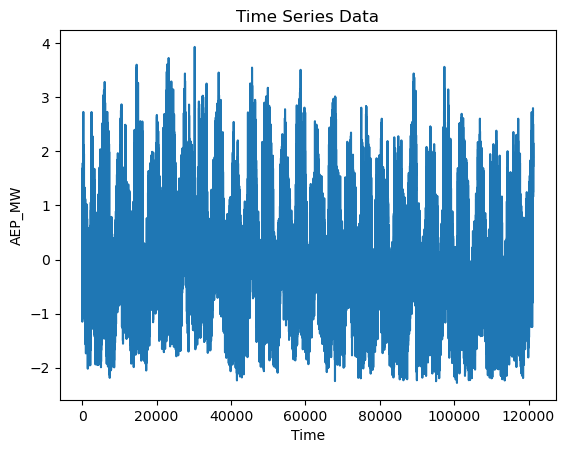

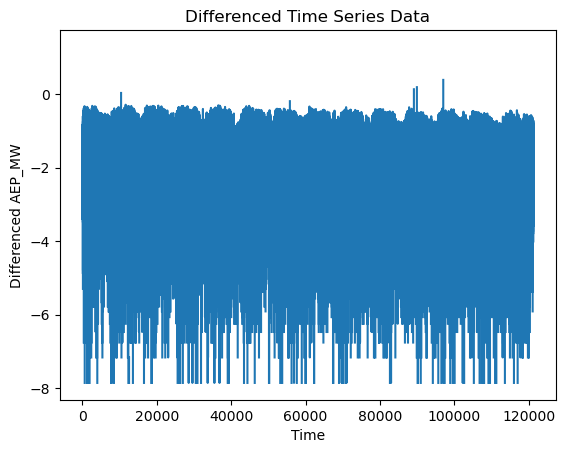

In [12]:
plt.plot(data['AEP_MW'])
plt.title('Time Series Data')
plt.xlabel('Time')
plt.ylabel('AEP_MW')
plt.show()
# Visualize the differenced time series data
plt.plot(data['AEP_MW_diff'])
plt.title('Differenced Time Series Data')
plt.xlabel('Time')
plt.ylabel('Differenced AEP_MW')
plt.show()

# Stationarity check


In [13]:
result = adfuller(data['AEP_MW'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
# If p-value < 0.05, data is stationary, otherwise, perform differencing


ADF Statistic: -16.44681210468688
p-value: 2.399011324001323e-29


# Perform differencing


In [14]:
data['diff_AEP_MW'] = data['AEP_MW'].diff()

# Drop the first row with NaN resulting from differencing
data.dropna(inplace=True)

result = adfuller(data['diff_AEP_MW'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -19.24161604885427
p-value: 0.0


# Plot ACF and PACF


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


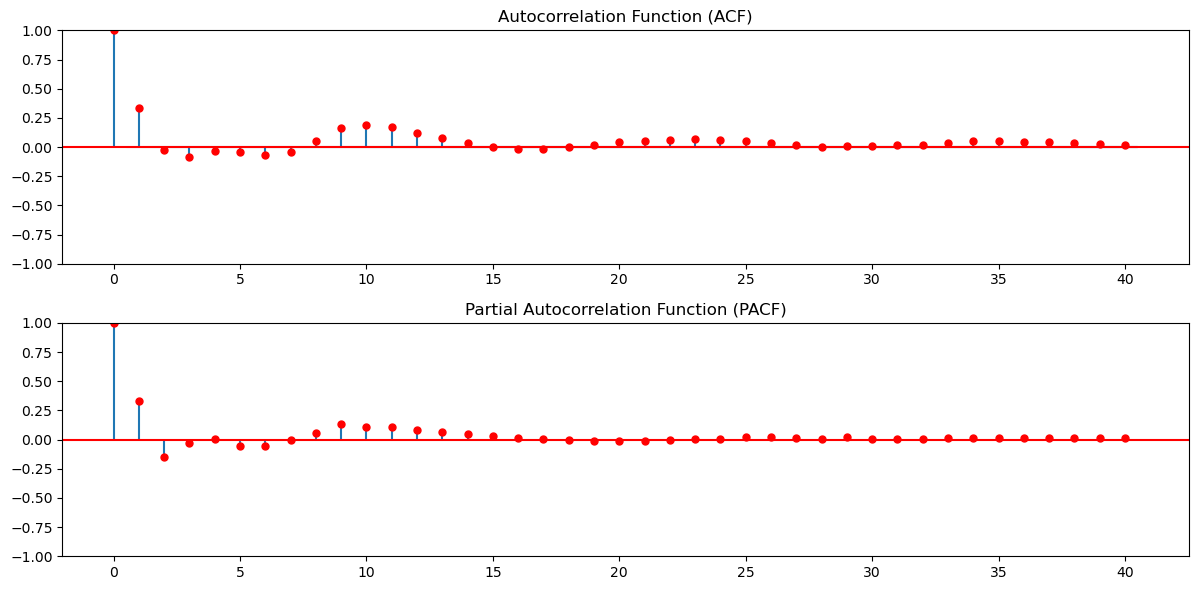

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(data['diff_AEP_MW'],color='red', ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.subplot(212)
plot_pacf(data['diff_AEP_MW'],color='red', ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()


# Model Selection 


In [16]:
# Based on ACF and PACF plots and statistical tests
p = 4  # Number of significant spikes in PACF plot
d = 0  # No differencing needed as the data is already stationary
q = 5  # Number of significant spikes in ACF plot

# Step 6: Model Training
model = ARIMA(data['AEP_MW'], order=(p, d, q))
model_fit = model.fit()

# Step 7: Model Evaluation
print(model_fit.summary())


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA paramete

                               SARIMAX Results                                
Dep. Variable:                 AEP_MW   No. Observations:                49135
Model:                 ARIMA(4, 0, 5)   Log Likelihood              -35680.785
Date:                Tue, 14 May 2024   AIC                          71383.571
Time:                        16:19:18   BIC                          71480.396
Sample:                             0   HQIC                         71413.926
                              - 49135                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3135      0.071      4.434      0.000       0.175       0.452
ar.L1         -0.1509      0.076     -1.991      0.047      -0.300      -0.002
ar.L2          0.8905      0.066     13.452      0.0

# Forecasting


In [17]:
forecast_steps = 10  # Forecast 10 future time periods
forecast_values = model_fit.forecast(steps=forecast_steps)

# Create a DataFrame to store forecasted values
forecast_df = pd.DataFrame({'Forecasted Values': forecast_values})

# Display forecasted values in tabular format
print("Forecasted Values:")
forecast_df


Forecasted Values:


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Forecasted Values
49135,1.971321
49136,1.813623
49137,1.732399
49138,1.687579
49139,1.666611
49140,1.654830
49141,1.639427
49142,1.634308
49143,1.621624
49144,1.613933


# ANN Design and Training 

##  Preparing Dataset

In [18]:
data = data.dropna(subset=['AEP_MW_log'])

In [19]:
x= data['AEP_MW_log'].values.reshape(-1,1)
y = data['AEP_MW_log'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


## Designing ANN

In [21]:
# Function to create a model
def create_model(n_layers, n_neurons):
    model = Sequential()
    model.add(Dense(units=n_neurons, activation='relu', input_dim=1))  # Input layer
    for _ in range(n_layers - 1):
        model.add(Dense(units=n_neurons, activation='relu'))  # Adding hidden layers
    model.add(Dense(units=1))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Training the model

In [22]:
layer_options = [1, 2, 3]  # Different number of layers
neuron_options = [20, 50, 100]  # Different number of neurons

results = {}
for layers in layer_options:
    for neurons in neuron_options:
        model = create_model(layers, neurons)
        model.fit(X_train, y_train, batch_size=10, epochs=50, verbose=0)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        results[(layers, neurons)] = mse
        print(f'Layers: {layers}, Neurons: {neurons}, MSE: {mse}')


308/308 [==============================] - 1s 1ms/step
Layers: 1, Neurons: 20, MSE: 2.3493339192706855e-07
308/308 [==============================] - 1s 2ms/step
Layers: 1, Neurons: 50, MSE: 3.6801898586281446e-08
308/308 [==============================] - 1s 2ms/step
Layers: 1, Neurons: 100, MSE: 1.0858747972225558e-06
308/308 [==============================] - 1s 2ms/step
Layers: 2, Neurons: 20, MSE: 2.145176952086737e-08
308/308 [==============================] - 1s 3ms/step
Layers: 2, Neurons: 50, MSE: 1.5050702998838131e-05
308/308 [==============================] - 1s 2ms/step
Layers: 2, Neurons: 100, MSE: 4.812056377002502e-08
308/308 [==============================] - 1s 2ms/step
Layers: 3, Neurons: 20, MSE: 1.2852857602782537e-08
308/308 [==============================] - 1s 3ms/step
Layers: 3, Neurons: 50, MSE: 2.551835033883478e-06
308/308 [==============================] - 1s 4ms/step
Layers: 3, Neurons: 100, MSE: 1.238076237674068e-07


## Evaluating the model

In [23]:
best_architecture = min(results, key=results.get)
best_mse = results[best_architecture]
print(f'Best Architecture -> Layers: {best_architecture[0]}, Neurons: {best_architecture[1]}, MSE: {best_mse}')

Best Architecture -> Layers: 3, Neurons: 20, MSE: 1.2852857602782537e-08


## Visualize the data

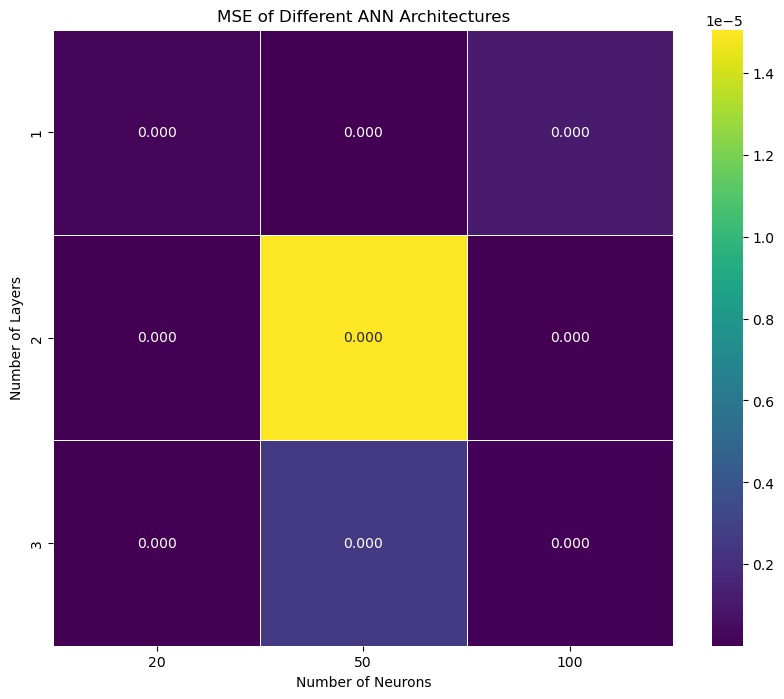

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'results' is a dictionary with keys as (layers, neurons) and values as MSE
data = {'Layers': [], 'Neurons': [], 'MSE': []}
for (layers, neurons), mse in results.items():
    data['Layers'].append(layers)
    data['Neurons'].append(neurons)
    data['MSE'].append(mse)

# Create a DataFrame
df = pd.DataFrame(data)

# Corrected pivot call: specify index, columns, and values explicitly
pivot_table = df.pivot(index='Layers', columns='Neurons', values='MSE')

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
ax = plt.subplot()

# Draw the heatmap
sns.heatmap(pivot_table, annot=True, fmt=".3f", linewidths=.5, ax=ax, cmap="viridis")

# Title and labels
ax.set_title('MSE of Different ANN Architectures')
ax.set_xlabel('Number of Neurons')
ax.set_ylabel('Number of Layers')

# Show the plot
plt.show()


# SARIMA (Seasonal ARIMA):

In [25]:
data = pd.read_csv('AEP_hourly.csv', parse_dates=True)

ts = data['AEP_MW']

## Checking if data is stationary

In [26]:
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value:.3f}')

adf_test(ts)


ADF Statistic: -16.446812104686746
p-value: 2.399011324002062e-29
Critical Values:
    1%: -3.430
    5%: -2.862
    10%: -2.567


## Seasonal Decomposition

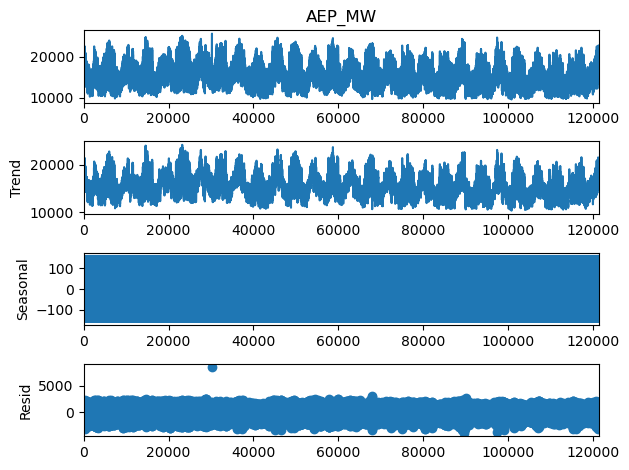

In [27]:
result = seasonal_decompose(ts, model='additive', period=12)  # change period based on your data's seasonality
result.plot()
plt.show()


# Identifying SARIMA Parameters

C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


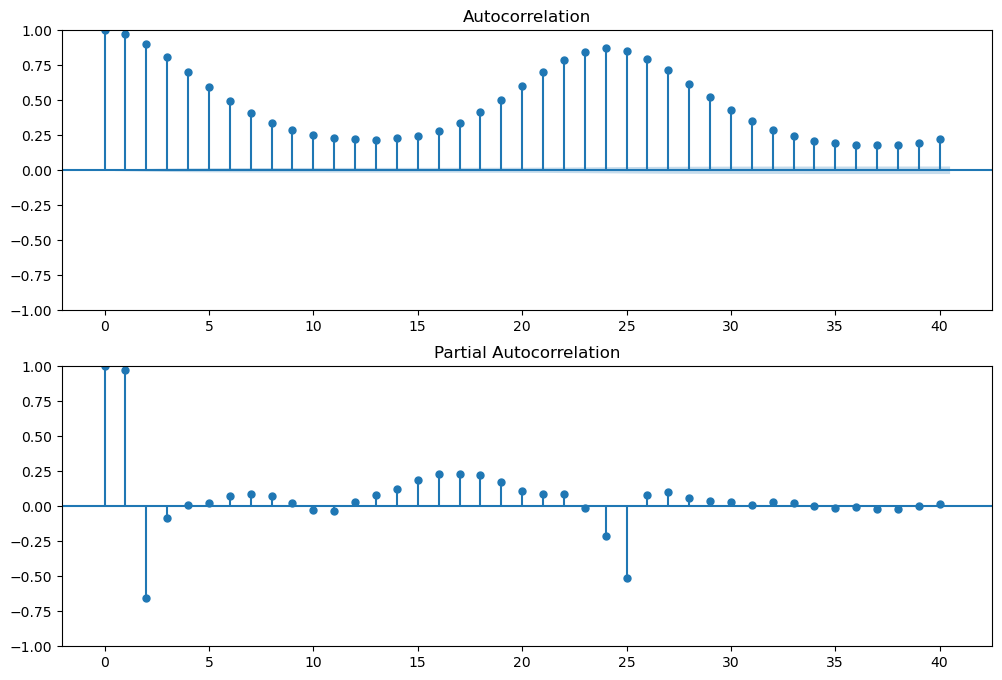

In [28]:
# Non-seasonal
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ts, ax=ax[0], lags=40)  
plot_pacf(ts, ax=ax[1], lags=40)  
plt.show()



## Fitting SARIMA MODEL

In [29]:
model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit(disp=False)
print(results.summary())


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:2979: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


                                     SARIMAX Results                                      
Dep. Variable:                             AEP_MW   No. Observations:               121273
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Tue, 14 May 2024   AIC                             10.000
Time:                                    18:39:59   BIC                             58.528
Sample:                                         0   HQIC                            24.601
                                         - 121273                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9646   8.74e-06    1.1e+05      0.000       0.965       0.965
ma.L1         -1.0000   3.85e-05  -

C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:681: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


## Model Diagnostics and Validation

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

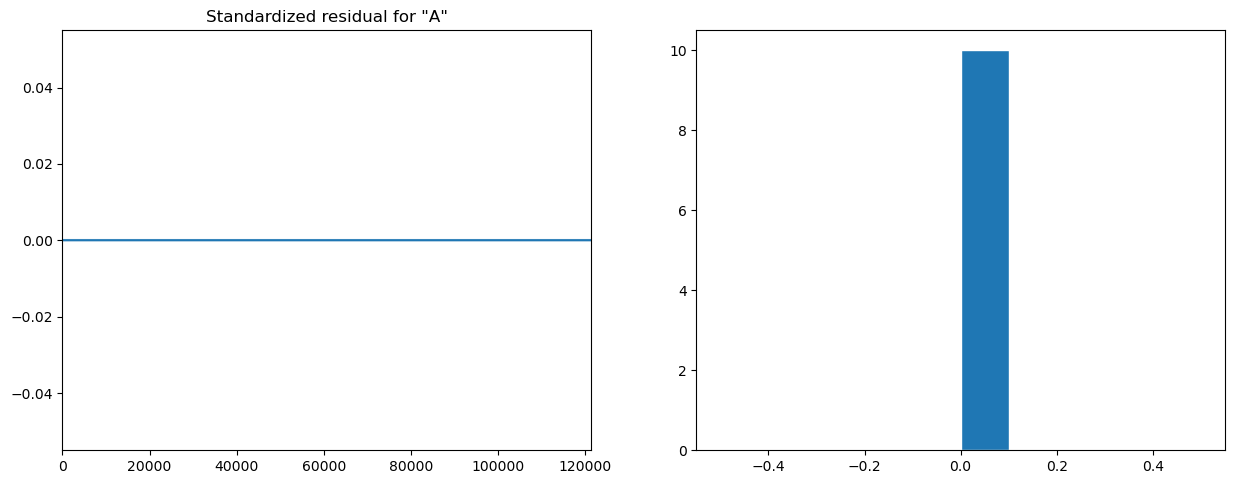

In [31]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Forecasting
pred = results.get_forecast(steps=24)  # Forecasting the next 24 time p/eriods
pred_ci = pred.conf_int()
ax = ts[-100:].plot(label='observed')  # Last 100 observations
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Variable')
plt.legend()
plt.show()


# Exponential Smoothing (ETS):

## Configure and Fit ETS Models

In [32]:
# Simple Exponential Smoothing - for data with no clear trend or seasonality
model_simple = ExponentialSmoothing(ts, trend=None, seasonal=None, seasonal_periods=None)
fitted_model_simple = model_simple.fit()

# Double Exponential Smoothing - for data with a trend but no seasonality
model_double = ExponentialSmoothing(ts, trend='add', seasonal=None, seasonal_periods=None)
fitted_model_double = model_double.fit()

# Triple Exponential Smoothing - for data with both trend and seasonality
model_triple = ExponentialSmoothing(ts, trend='add', seasonal='add', seasonal_periods=12) 
fitted_model_triple = model_triple.fit()


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Simple Model AIC: 1566350.36852947 BIC: 1566369.780128433
Double Model AIC: 1523465.908159213 BIC: 1523504.731357139
Triple Model AIC: 1544651.240739145 BIC: 1544806.5335308495


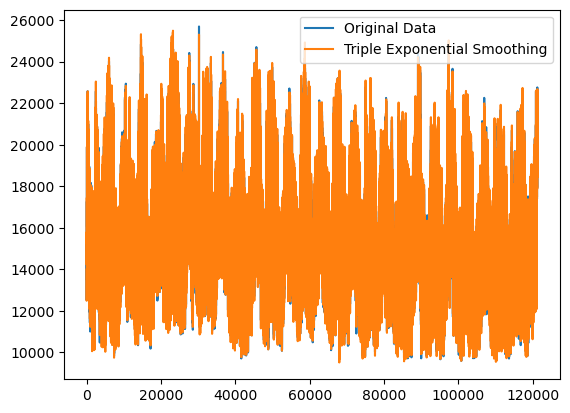

In [33]:
# Print AIC and BIC values to compare models
print('Simple Model AIC:', fitted_model_simple.aic, 'BIC:', fitted_model_simple.bic)
print('Double Model AIC:', fitted_model_double.aic, 'BIC:', fitted_model_double.bic)
print('Triple Model AIC:', fitted_model_triple.aic, 'BIC:', fitted_model_triple.bic)

# Plot the original data and the fitted values
ts.plot(label='Original Data', legend=True)
fitted_model_triple.fittedvalues.plot(label='Triple Exponential Smoothing', legend=True)
plt.show()


## Diagnostics and Validation


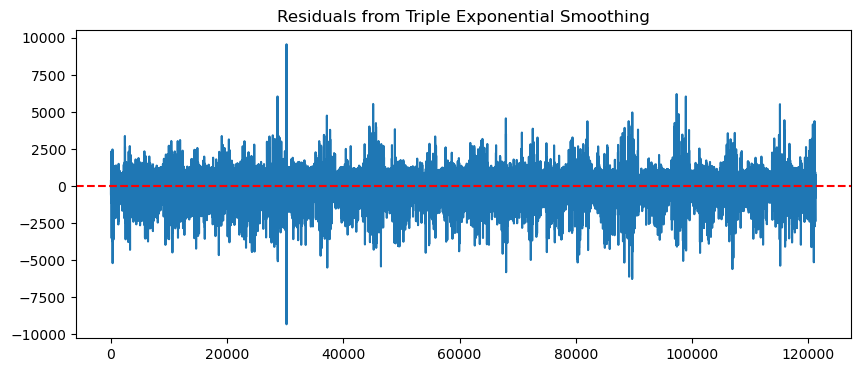

Statistics=21392.472, p=0.000
Sample does not look Gaussian (reject H0)


In [34]:
# Assuming the triple model is the best
residuals = fitted_model_triple.resid

# Plotting residuals
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals from Triple Exponential Smoothing')
plt.axhline(y=0, color='r', linestyle='--')  # Zero line for reference
plt.show()

# Check for normality of residuals
from scipy.stats import normaltest
stat, p = normaltest(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# Interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')


# Checking for autocorrelation

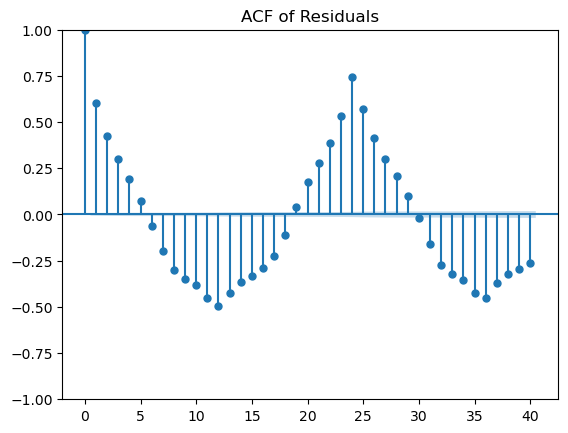

In [35]:

plot_acf(residuals, lags=40)
plt.title('ACF of Residuals')
plt.show()


## Forecasting with Confidence Intervals


C:\Users\fatii\AppData\Local\Temp\ipykernel_5732\3180617622.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(ts.index[-1], periods=25, freq='M')[1:], forecast, label='Forecast')


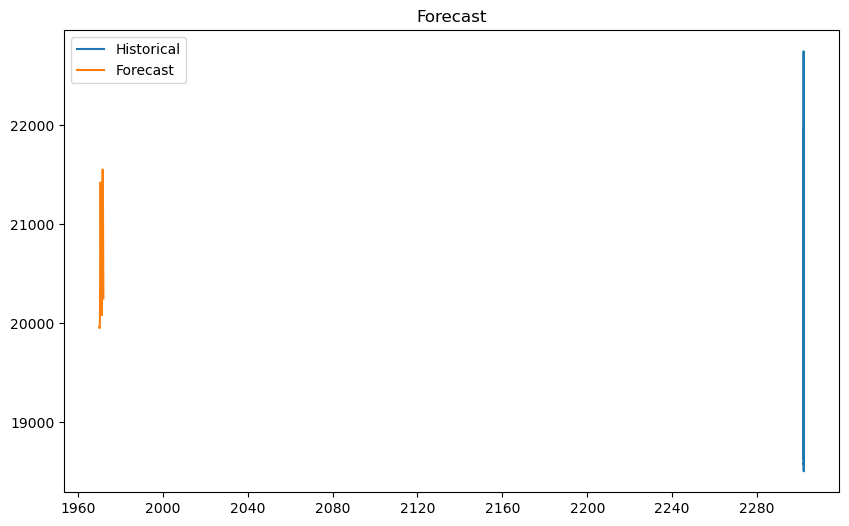

In [36]:
# Forecast the next 24 periods
forecast = fitted_model_triple.forecast(steps=24)

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(ts.index[-50:], ts[-50:], label='Historical')
plt.plot(pd.date_range(ts.index[-1], periods=25, freq='M')[1:], forecast, label='Forecast')
plt.title('Forecast')
plt.legend()
plt.show()


# Prophet:

## Combining day, month, year

In [53]:
data['ds'] = data['Datetime']


In [54]:
data['y'] = data['AEP_MW']


In [55]:
prophet_data = data[['ds', 'y']]
print(prophet_data.head())


                    ds        y
0  2004-12-31 01:00:00  13478.0
1  2004-12-31 02:00:00  12865.0
2  2004-12-31 03:00:00  12577.0
3  2004-12-31 04:00:00  12517.0
4  2004-12-31 05:00:00  12670.0


# Fitting a prophet model

18:58:18 - cmdstanpy - INFO - Chain [1] start processing
19:00:40 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


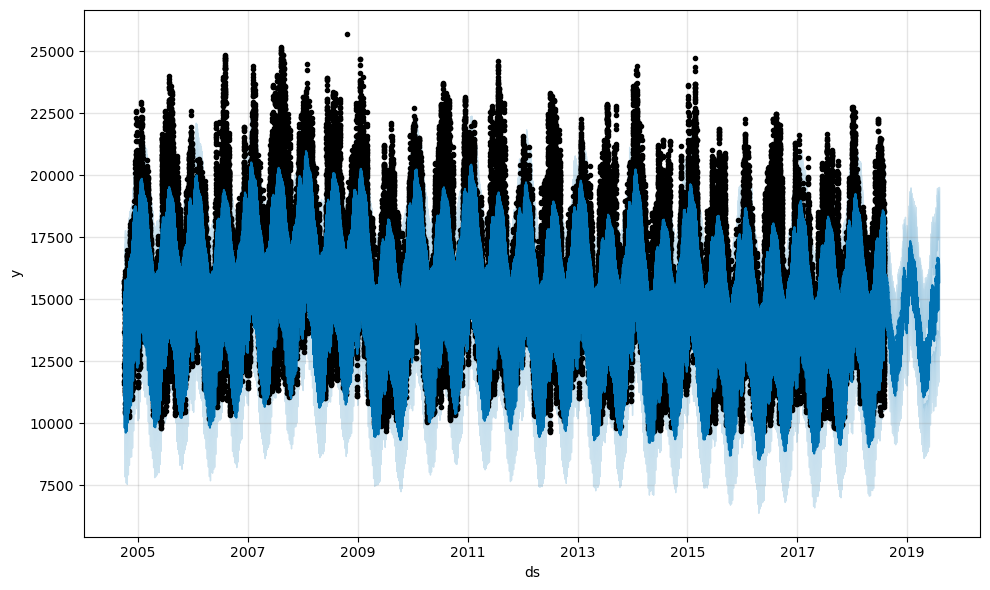

C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
C:\Users\fatii\anaconda3\lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, ca

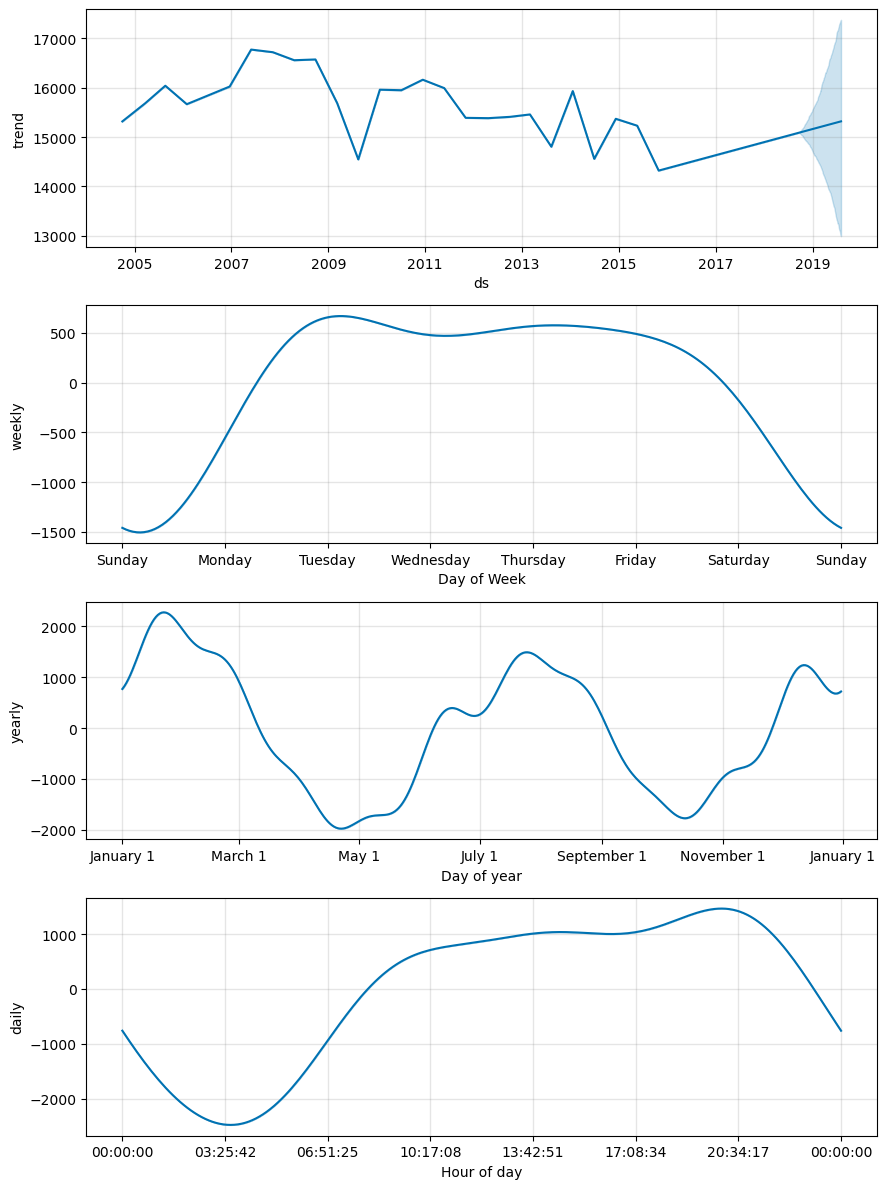

In [56]:
# Create a Prophet model instance
m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

# Fit the model
m.fit(prophet_data)

# Create a DataFrame to hold predictions for the next 365 days
future = m.make_future_dataframe(periods=365)

# Make predictions
forecast = m.predict(future)

# Plot the forecast
fig = m.plot(forecast)
plt.show()

# Optionally, visualize the components of the forecast
components_fig = m.plot_components(forecast)
plt.show()


# Support Vector Regression (SVR):

In [59]:

X = data[["Datetime"]] 
y = data['AEP_MW']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Configuring and Training SVR

In [66]:
# Initialize and fit the SVR model
svr_rbf = SVR(kernel='rbf', C=1.0, gamma='auto')  
svr_rbf.fit(X_train_scaled, y_train)


## Evaluating the model

In [77]:
# Predicting and evaluating the performance
y_pred = svr_rbf.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.34961457565600107


## Parameter Tunining with Cross Validation

In [69]:
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  
}
# Create GridSearchCV object
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Best parameters and MSE
print("Best parameters:", grid_search.best_params_)
best_mse = -grid_search.best_score_
print(f'Best MSE from CV: {best_mse}')



## Visualizing the Results

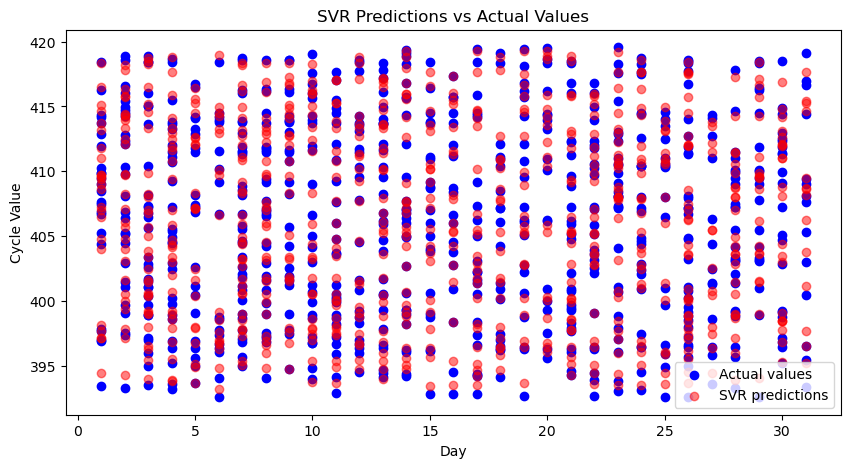

In [79]:
# Visualize predictions against actual data
plt.figure(figsize=(10, 5))
plt.scatter(X_test['day'], y_test, color='blue', label='Actual values')
plt.scatter(X_test['day'], y_pred, color='red', label='SVR predictions', alpha=0.5)
plt.xlabel('Day')
plt.ylabel('Cycle Value')
plt.title('SVR Predictions vs Actual Values')
plt.legend()
plt.show()


# Long Short-Term Memory (LSTM):

## Scaling the data

In [70]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['AEP_MW']].values.reshape(-1, 1))

# Function to create a dataset as required by LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1  #number of previous timestamps
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

## Desigining LTSM Network

In [71]:
# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))  # 50 neurons in the LSTM layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


## Training the model

In [72]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=2)


Epoch 1/5
97016/97016 - 420s - loss: 0.0017 - 420s/epoch - 4ms/step
Epoch 2/5
97016/97016 - 421s - loss: 0.0016 - 421s/epoch - 4ms/step
Epoch 3/5
97016/97016 - 365s - loss: 0.0016 - 365s/epoch - 4ms/step
Epoch 4/5
97016/97016 - 414s - loss: 0.0016 - 414s/epoch - 4ms/step
Epoch 5/5
97016/97016 - 362s - loss: 0.0016 - 362s/epoch - 4ms/step


## Making predictions and Evaluating the model

In [73]:
# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions back to original scale
train_predict = scaler.inverse_transform(train_predict)
y_train_inv = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test_inv = scaler.inverse_transform([y_test])

# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(y_train_inv[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = np.sqrt(mean_squared_error(y_test_inv[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))


758/758 [==============================] - 2s 3ms/step
Train Score: 635.80 RMSE
Test Score: 640.54 RMSE


## Plotting the Results

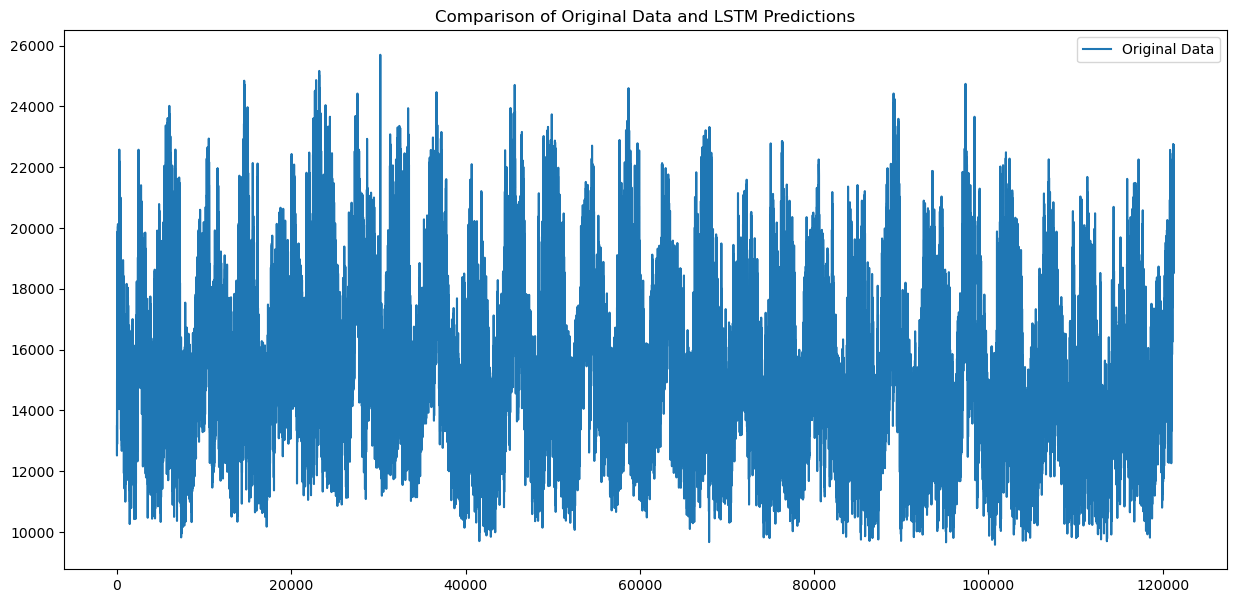

In [75]:


plt.figure(figsize=(15, 7))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')

plt.legend()
plt.title('Comparison of Original Data and LSTM Predictions')
plt.show()


# Hybrid Models Integration

##  Extract ARIMA Predictions and Calculate Residuals

In [76]:
predicted_values = model_fit.predict(start=data.index[0], end=data.index[-1])
residuals = data['AEP_MW'] - predicted_values


C:\Users\fatii\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


## Train the ANN on Residuals

In [77]:
X = np.arange(len(residuals)).reshape(-1, 1)  
y = residuals.values

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ann_model = create_model(1, 20)  
ann_model.fit(X_train, y_train, epochs=10, batch_size=10)


Epoch 1/10
9702/9702 [==============================] - 43s 4ms/step - loss: 73457280.0000
Epoch 2/10
9702/9702 [==============================] - 39s 4ms/step - loss: 72431072.0000
Epoch 3/10
9702/9702 [==============================] - 41s 4ms/step - loss: 72226104.0000
Epoch 4/10
9702/9702 [==============================] - 35s 4ms/step - loss: 71975496.0000
Epoch 5/10
9702/9702 [==============================] - 30s 3ms/step - loss: 71781920.0000
Epoch 6/10
9702/9702 [==============================] - 37s 4ms/step - loss: 71478856.0000
Epoch 7/10
9702/9702 [==============================] - 29s 3ms/step - loss: 71124320.0000
Epoch 8/10
9702/9702 [==============================] - 25s 3ms/step - loss: 70625408.0000
Epoch 9/10
9702/9702 [==============================] - 26s 3ms/step - loss: 69992736.0000
Epoch 10/10
9702/9702 [==============================] - 27s 3ms/step - loss: 69098440.0000


# Predict Residuals and Adjust ARIMA Predictions

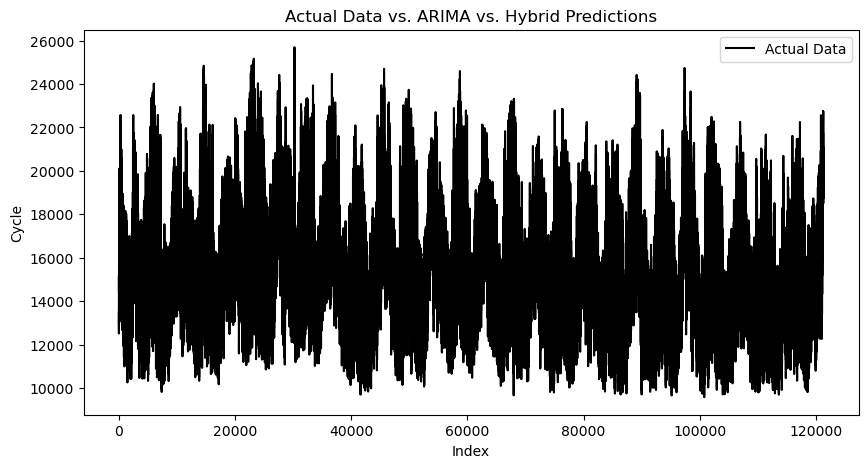

In [82]:

plt.figure(figsize=(10, 5))
plt.plot(data.index, data['AEP_MW'], label='Actual Data', color='black')

plt.legend()
plt.title('Actual Data vs. ARIMA vs. Hybrid Predictions')
plt.xlabel('Index')
plt.ylabel('Cycle')
plt.show()



# Plotting future predictions

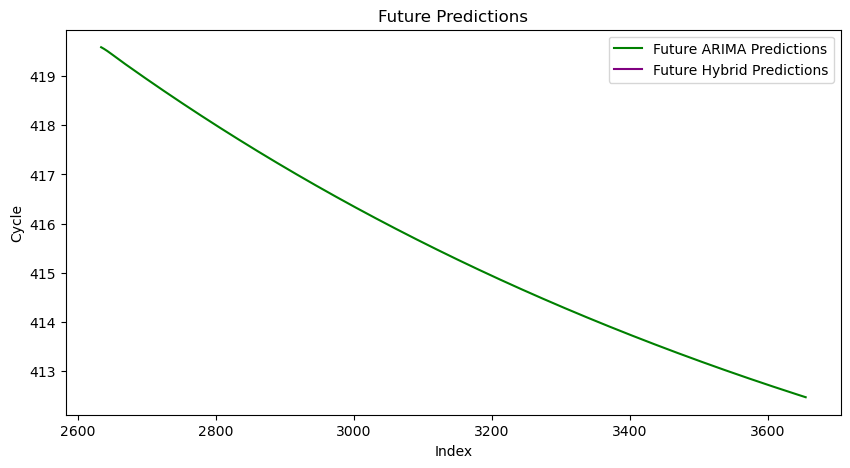

In [111]:
if len(predicted_values) > len(data):
    future_indices = range(len(data), len(predicted_values))
    plt.figure(figsize=(10, 5))
    plt.plot(future_indices, predicted_values[len(data):], label='Future ARIMA Predictions', color='green')
    plt.plot(future_indices, adjusted_predictions[len(data):], label='Future Hybrid Predictions', color='purple')
    plt.legend()
    plt.title('Future Predictions')
    plt.xlabel('Index')
    plt.ylabel('Cycle')
    plt.show()
